In [9]:
!pip install openpyxl


   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]



In [5]:
!pip install metpy

   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   --------------------- ------------------ 3.4/6.3 MB 15.5 MB/s eta 0:00:01
   ---------------------------------------- 6.3/6.3 MB 19.2 MB/s eta 0:00:00

   -------------------- ------------------- 3/6 [pooch]
   -------------------------- ------------- 4/6 [pint]
   --------------------------------- ------ 5/6 [metpy]
   ---------------------------------------- 6/6 [metpy]



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import openpyxl
import pandas as pd
import os
from metpy.calc import wind_components
from metpy.units import units


In [12]:
def read_data(path):
    dtype_dict = {
        'Station': 'string',
        'Date/Time': 'string',
        'Air Dew Point': 'float',
        'Air Temperature (OC)': 'float',
        'Humidity %': 'float',
        'Atmospheric Pressure': 'float',
        'Liquid Precipitation': 'float',
        'Manual Present Weather …': 'string',
        'Cloud Type': 'string',
        'Clouds Cover (Okta)': 'float',
        'Cloud Cover %': 'float',
        'Snow Depth.depth In CM': 'float',
        'Horizontal Visibility In m.': 'float',
        'Wind Direction (Degrees)': 'float',
        'Wind Speed (MPS)': 'float',
        'Wind Type': 'string',
        'Wind Gust speed': 'float',
    }

    # Read the Excel file
    df = pd.read_excel(
        path,
        skiprows=5,
        dtype=dtype_dict,
        na_values=['Null', 'N/A', '--', 'sky obscured or cloud amount cannot be estimated']
    )

    # Standardize column names
    if 'liquid Precipitation depth In MM' in df.columns:
        df.rename(columns={'liquid Precipitation depth In MM': 'Liquid Precipitation'}, inplace=True)
    elif 'Liquid Precipitation' in df.columns:
        df.rename(columns={'Liquid Precipitation': 'Liquid Precipitation'}, inplace=True)  # Ensure consistent name
    if 'Snow Depth.depth In CM' in df.columns:
        df.rename(columns={'Snow Depth.depth In CM': 'Snow Depth'}, inplace=True)
    elif 'Snow Depth' in df.columns:
        df.rename(columns={'Snow Depth': 'Snow Depth'}, inplace=True)  # Ensure consistent name
    if 'Manual Present Weather …' in df.columns:
        df.rename(columns={'Manual Present Weather …': 'Manual Present Weather'}, inplace=True)
    elif 'Snow Depth' in df.columns:
        df.rename(columns={'Manual Present Weather': 'Manual Present Weather'}, inplace=True)  # Ensure consistent name

    # Convert the 'Date/Time' column to datetime format
    df['Date/Time'] = pd.to_datetime(df['Date/Time'], errors='coerce')


    # Set 'Date/Time' as the index for time series operations
    df.set_index('Date/Time', inplace=True)
    df = df.sort_index()

    return df


In [13]:
amman = read_data('Queen Alia Airport   01-07-1983 - 30-05-2024.xlsx')

In [14]:
amman.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 336486 entries, 1983-07-01 00:00:00 to 2024-05-30 21:00:00
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Station                      336485 non-null  string 
 1   Air Dew Point                333150 non-null  float64
 2   Air Temperature (OC)         333620 non-null  float64
 3   Humidity %                   332892 non-null  float64
 4   Atmospheric Pressure         99914 non-null   float64
 5   Liquid Precipitation         2481 non-null    float64
 6   Manual Present Weather       156730 non-null  string 
 7   Cloud Type                   34654 non-null   string 
 8   Clouds Cover (Okta)          104471 non-null  float64
 9   Cloud Cover %                335898 non-null  float64
 10  Snow Depth                   226 non-null     float64
 11  Horizontal Visibility In m.  324480 non-null  float64
 12  Wind Direction (Degrees)

In [15]:
amman.drop(['Unnamed: 17', 'Wind Gust speed', 'Wind Type','Horizontal Visibility In m.','Snow Depth', 'Clouds Cover (Okta)', 'Cloud Type'], axis=1, inplace=True)

In [16]:
amman = amman[amman.index > '2023-12-31']

In [17]:
amman.drop(['Station','Manual Present Weather'], axis = 1, inplace = True)
amman.columns

Index(['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
       'Atmospheric Pressure', 'Liquid Precipitation', 'Cloud Cover %',
       'Wind Direction (Degrees)', 'Wind Speed (MPS)'],
      dtype='object')

In [18]:
cols = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
       'Atmospheric Pressure',
       'Wind Direction (Degrees)', 'Wind Speed (MPS)']

In [19]:
df = amman.copy()

In [20]:
for col in cols:
    df[col] = df.groupby(df.index)[col].transform(lambda x: x.ffill().bfill())
    
df = df[~df.index.duplicated(keep='first')]


In [21]:
df.index = pd.to_datetime(df.index)


In [22]:
for year in df.index.year.unique():
  print(f"Year: {year}")
  print("Unique Months:", np.sort(df[df.index.year == year].index.month.unique()))
  print("Unique Days:", np.sort(df[df.index.year == year].index.day.unique()))
  print("Unique Days of Week:", np.sort(df[df.index.year == year].index.dayofweek.unique()))
  print("Unique Hours:", np.sort(df[df.index.year == year].index.hour.unique()))
  print("-" * 20)

Year: 2023
Unique Months: [12]
Unique Days: [31]
Unique Days of Week: [6]
Unique Hours: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
--------------------
Year: 2024
Unique Months: [1 2 3 4 5]
Unique Days: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Unique Days of Week: [0 1 2 3 4 5 6]
Unique Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
--------------------


In [23]:
date_range = pd.date_range(start = df.index.min(),end =df.index.max(), freq="D")
missing_dates = date_range[~date_range.isin(df.index)]
missing_dates

DatetimeIndex(['2024-02-26 01:00:00', '2024-03-27 01:00:00',
               '2024-03-28 01:00:00', '2024-03-29 01:00:00',
               '2024-03-30 01:00:00', '2024-03-31 01:00:00',
               '2024-04-01 01:00:00', '2024-05-01 01:00:00',
               '2024-05-06 01:00:00'],
              dtype='datetime64[ns]', freq=None)

In [24]:
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df = df.reindex(full_range)
df.head()

C:\Users\20210291\AppData\Local\Temp\ipykernel_20352\114224145.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Liquid Precipitation,Cloud Cover %,Wind Direction (Degrees),Wind Speed (MPS)
2023-12-31 01:00:00,6.0,7.0,93.352226,NaN,NaN,0.0,NaN,0.0
2023-12-31 02:00:00,6.0,6.0,100.000000,NaN,NaN,0.0,110.0,3.1
2023-12-31 03:00:00,4.5,5.4,93.923673,1022.099976,NaN,37.5,340.0,2.1
2023-12-31 04:00:00,5.0,5.0,100.000000,NaN,NaN,0.0,NaN,0.0
2023-12-31 05:00:00,5.0,5.0,100.000000,NaN,NaN,0.0,NaN,0.0


In [25]:
for column in cols:
  df[column] = df[column].interpolate(method='ffill')
  df[column] = df[column].interpolate(method='bfill')
df.tail()

C:\Users\20210291\AppData\Local\Temp\ipykernel_20352\223796282.py:2: FutureWarning: Series.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].interpolate(method='ffill')
C:\Users\20210291\AppData\Local\Temp\ipykernel_20352\223796282.py:3: FutureWarning: Series.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].interpolate(method='bfill')


,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Liquid Precipitation,Cloud Cover %,Wind Direction (Degrees),Wind Speed (MPS)
2024-05-30 17:00:00,11.0,21.0,52.802638,1012.299988,NaN,0.0,290.0,7.7
2024-05-30 18:00:00,9.6,19.4,53.092129,1014.099976,NaN,25.0,300.0,5.7
2024-05-30 19:00:00,11.0,17.0,67.769404,1014.099976,NaN,0.0,270.0,2.1
2024-05-30 20:00:00,12.0,17.0,72.401375,1014.099976,NaN,0.0,300.0,3.6
2024-05-30 21:00:00,11.1,15.4,75.545003,1015.000000,NaN,25.0,280.0,2.1


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3645 entries, 2023-12-31 01:00:00 to 2024-05-30 21:00:00
Freq: h
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Air Dew Point             3645 non-null   float64
 1   Air Temperature (OC)      3645 non-null   float64
 2   Humidity %                3645 non-null   float64
 3   Atmospheric Pressure      3645 non-null   float64
 4   Liquid Precipitation      84 non-null     float64
 5   Cloud Cover %             3444 non-null   float64
 6   Wind Direction (Degrees)  3645 non-null   float64
 7   Wind Speed (MPS)          3645 non-null   float64
dtypes: float64(8)
memory usage: 256.3 KB


In [27]:
df['Liquid Precipitation'].fillna(0, inplace = True )
df['Cloud Cover %'].fillna(0, inplace = True)

C:\Users\20210291\AppData\Local\Temp\ipykernel_20352\4267059986.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Liquid Precipitation'].fillna(0, inplace = True )
C:\Users\20210291\AppData\Local\Temp\ipykernel_20352\4267059986.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

In [28]:
u, v = wind_components(
    df['Wind Speed (MPS)'].values * units('m/s'),
    df['Wind Direction (Degrees)'].values * units.degree
)

df['Wind_U'] = u.magnitude  
df['Wind_V'] = v.magnitude

# OR the following, the above code is based on a specialaized library "metpy"

# df['Wind_U'] = -df['Wind Speed (MPS)'] * np.sin(np.radians(df['Wind Direction (Degrees)']))
# df['Wind_V'] = -df['Wind Speed (MPS)'] * np.cos(np.radians(df['Wind Direction (Degrees)']))
df.Wind_U = df.Wind_U.round(2)
df.Wind_V = df.Wind_V.round(2)
df.head()

,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Liquid Precipitation,Cloud Cover %,Wind Direction (Degrees),Wind Speed (MPS),Wind_U,Wind_V
2023-12-31 01:00:00,6.0,7.0,93.352226,1022.099976,0.0,0.0,110.0,0.0,-0.00,0.00
2023-12-31 02:00:00,6.0,6.0,100.000000,1022.099976,0.0,0.0,110.0,3.1,-2.91,1.06
2023-12-31 03:00:00,4.5,5.4,93.923673,1022.099976,0.0,37.5,340.0,2.1,0.72,-1.97
2023-12-31 04:00:00,5.0,5.0,100.000000,1022.099976,0.0,0.0,340.0,0.0,0.00,-0.00
2023-12-31 05:00:00,5.0,5.0,100.000000,1022.099976,0.0,0.0,340.0,0.0,0.00,-0.00


In [29]:
df.drop(['Wind Speed (MPS)', 'Wind Direction (Degrees)'], axis=1, inplace=True)
df.tail()

,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Liquid Precipitation,Cloud Cover %,Wind_U,Wind_V
2024-05-30 17:00:00,11.0,21.0,52.802638,1012.299988,0.0,0.0,7.24,-2.63
2024-05-30 18:00:00,9.6,19.4,53.092129,1014.099976,0.0,25.0,4.94,-2.85
2024-05-30 19:00:00,11.0,17.0,67.769404,1014.099976,0.0,0.0,2.10,0.00
2024-05-30 20:00:00,12.0,17.0,72.401375,1014.099976,0.0,0.0,3.12,-1.80
2024-05-30 21:00:00,11.1,15.4,75.545003,1015.000000,0.0,25.0,2.07,-0.36


In [30]:
df['Liquid Precipitation'].unique()

array([0.        , 2.        , 1.        , 4.        , 5.        ,
       6.        , 0.40000001, 0.80000001, 0.5       , 3.        ,
       1.39999998, 0.1       , 7.        , 8.        , 0.30000001,
       9.        , 8.89999962, 6.69999981, 0.2       , 0.69999999,
       6.5999999 ])

In [44]:
for col in df.columns:
    df[col] = round(df[col], 4)



In [46]:
df.to_csv('amman_test.csv')
df['Liquid Precipitation'].unique()

array([0. , 2. , 1. , 4. , 5. , 6. , 0.4, 0.8, 0.5, 3. , 1.4, 0.1, 7. ,
       8. , 0.3, 9. , 8.9, 6.7, 0.2, 0.7, 6.6])

<Axes: >

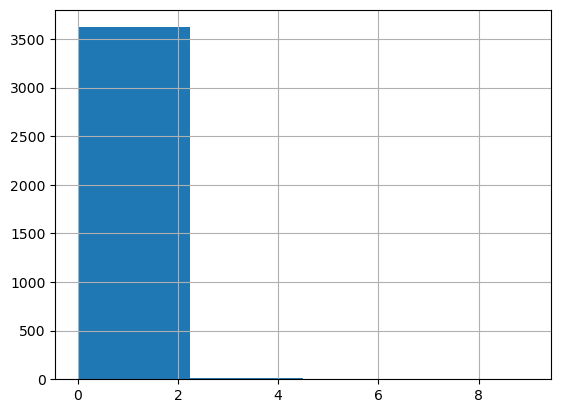

In [51]:
df['Liquid Precipitation'].hist(bins = 4)

In [32]:
violent_columns = ['Air Dew Point', 'Wind_U', 'Wind_V']
for col in violent_columns:
    df[col] = df[col].rolling(window=15, center=True).mean().fillna(method='bfill').fillna(method='ffill')
df['Atmospheric Pressure'] = df['Atmospheric Pressure'].rolling(window=10, center=True).mean().fillna(method='bfill').fillna(method='ffill')


C:\Users\20210291\AppData\Local\Temp\ipykernel_20352\3939453551.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].rolling(window=15, center=True).mean().fillna(method='bfill').fillna(method='ffill')
C:\Users\20210291\AppData\Local\Temp\ipykernel_20352\3939453551.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Atmospheric Pressure'] = df['Atmospheric Pressure'].rolling(window=10, center=True).mean().fillna(method='bfill').fillna(method='ffill')


NameError: name 'final' is not defined

In [36]:
df.to_csv('amman_test.csv')